# Example to train a model
Using the openstf tasks

In [1]:
import pandas as pd
import IPython
from openstef.pipeline.train_model import train_model_pipeline
from openstef.pipeline.create_forecast import create_forecast_pipeline
from openstef.metrics import metrics
from openstef.data_classes.prediction_job import PredictionJobDataClass

2023-01-26 16:19:07 [info     ] Proloaf not available, setting constructor to None


In [34]:
# define properties of training/prediction. We call this a 'prediction_job'
pj=dict(id=287,
        model='xgb',
        quantiles=[0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95],
        name="backtest",
        forecast_type="demand",
        lat=52.0,
        lon=5.0,
        horizon_minutes=47*60,
        description="description",
        resolution_minutes=15,
        hyper_params={}, # Note, this should become optional
        feature_names=None, # Note, this should become optional
       )

pj  = PredictionJobDataClass(**pj)

# Load input data
input_data = pd.read_csv('data/get_model_input_pid_287.csv', index_col='index', parse_dates=True)
# Last 200 rows are empty, remove them
input_data = input_data.iloc[:-200,:]

# Split in training and forecasting data
train_data = input_data.iloc[:-200,:] # everything except last 200 rows (~ 48 hours)
test_indices = input_data.iloc[-200:,:].index # last 200 rows

In [3]:
train_data.head()

,load,APX,clouds,radiation,temp,winddeg,windspeed,windspeed_100m,pressure,humidity,...,sjv_E1A,sjv_E1B,sjv_E1C,sjv_E2A,sjv_E2B,sjv_E3A,sjv_E3B,sjv_E3C,sjv_E3D,sjv_E4A
index,,,,,,,,,,,,,,,,,,,,,
2020-10-02 09:45:00+00:00,3.310000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-02 10:00:00+00:00,2.620000,34.0,99.758911,1.552899e+06,16.449036,154.711456,3.527778,9.349441,99453.476562,0.686240,...,0.000031,0.000030,0.000029,0.000033,0.000032,0.000061,0.000048,0.000048,0.000031,0.0
2020-10-02 10:15:00+00:00,0.796667,34.0,99.819193,1.575618e+06,16.400948,157.491554,3.557639,9.232026,99416.363281,0.683780,...,0.000032,0.000030,0.000029,0.000033,0.000032,0.000060,0.000048,0.000048,0.000031,0.0
2020-10-02 10:30:00+00:00,0.300000,34.0,99.879475,1.598338e+06,16.352859,160.271652,3.587500,9.114612,99379.250000,0.681319,...,0.000032,0.000031,0.000029,0.000033,0.000031,0.000058,0.000048,0.000048,0.000031,0.0
2020-10-02 10:45:00+00:00,1.773333,34.0,99.939756,1.594736e+06,16.304771,163.051750,3.617361,8.997197,99342.136719,0.678859,...,0.000032,0.000030,0.000029,0.000032,0.000031,0.000057,0.000048,0.000048,0.000031,0.0


In [5]:
to_forecast_data.head()

,load,APX,clouds,radiation,temp,winddeg,windspeed,windspeed_100m,pressure,humidity,...,sjv_E1A,sjv_E1B,sjv_E1C,sjv_E2A,sjv_E2B,sjv_E3A,sjv_E3B,sjv_E3C,sjv_E3D,sjv_E4A
index,,,,,,,,,,,,,,,,,,,,,
2020-10-02 09:45:00+00:00,3.310000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-02 10:00:00+00:00,2.620000,34.0,99.758911,1.552899e+06,16.449036,154.711456,3.527778,9.349441,99453.476562,0.686240,...,0.000031,0.000030,0.000029,0.000033,0.000032,0.000061,0.000048,0.000048,0.000031,0.0
2020-10-02 10:15:00+00:00,0.796667,34.0,99.819193,1.575618e+06,16.400948,157.491554,3.557639,9.232026,99416.363281,0.683780,...,0.000032,0.000030,0.000029,0.000033,0.000032,0.000060,0.000048,0.000048,0.000031,0.0
2020-10-02 10:30:00+00:00,0.300000,34.0,99.879475,1.598338e+06,16.352859,160.271652,3.587500,9.114612,99379.250000,0.681319,...,0.000032,0.000031,0.000029,0.000033,0.000031,0.000058,0.000048,0.000048,0.000031,0.0
2020-10-02 10:45:00+00:00,1.773333,34.0,99.939756,1.594736e+06,16.304771,163.051750,3.617361,8.997197,99342.136719,0.678859,...,0.000032,0.000030,0.000029,0.000032,0.000031,0.000057,0.000048,0.000048,0.000031,0.0


# Train a model
Train a model using the high-level pipeline. Store the model and reports on training proces in ./trained_models

In [35]:
models = train_model_pipeline(
    pj,
    train_data,
    check_old_model_age=False,
    mlflow_tracking_uri="./trained_models",
    artifact_folder="./trained_models",
    )

2023-01-26 16:29:25 [debug    ] MLflow tracking uri at init= ./trained_models


Traceback (most recent call last):
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_

2023-01-26 16:29:25 [warning  ] feature_modules not an attribute of the old model, using None  experiment_name=287
2023-01-26 16:29:25 [info     ] Model successfully loaded with MLflow
2023-01-26 16:29:25 [info     ] Found 2 values of constant load (repeated values), converted to NaN value. cleansing_step=repeated_values frac_values=0.0001798399424512184 num_values=2 pj_id=287
2023-01-26 16:29:25 [info     ] Removed 2 NaN values           num_removed_values=2
2023-01-26 16:29:31 [info     ] New model is better than old model, continuing with training procces


Traceback (most recent call last):
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_

2023-01-26 16:29:35 [info     ] Model saved with MLflow        experiment_name=287
2023-01-26 16:29:37 [info     ] Logged figures to MLflow.
2023-01-26 16:29:37 [info     ] Writing reports to ./trained_models\287


Traceback (most recent call last):
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_

You can find the trained model in ./trained_models, along with reports on the training process

In [36]:
## Inspect local files
IPython.display.HTML(f"<iframe src=./trained_models/{pj['id']}/Predictor0.25.html width=800 height=400></iframe>"
                     f"<iframe src=./trained_models/{pj['id']}/Predictor47.0.html width=800 height=400></iframe>"
                     f"<iframe src=./trained_models/{pj['id']}/weight_plot.html width=800 height=400></iframe>")

C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\IPython\core\display.py:431: UserWarning:

Consider using IPython.display.IFrame instead



In [37]:
import numpy as np
realised = input_data.loc[test_indices, 'load'].copy(deep=True)
to_forecast_data = input_data.copy(deep=True)
to_forecast_data.loc[test_indices, 'load'] = np.nan

# Make a forecast
forecast = create_forecast_pipeline(pj, to_forecast_data, mlflow_tracking_uri="./trained_models",)

2023-01-26 16:29:39 [debug    ] MLflow tracking uri at init= ./trained_models


Traceback (most recent call last):
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_

2023-01-26 16:29:39 [warning  ] feature_modules not an attribute of the old model, using None  experiment_name=287
2023-01-26 16:29:39 [info     ] Model successfully loaded with MLflow
2023-01-26 16:29:39 [info     ] Found 202 values of constant load (repeated values), converted to NaN value. cleansing_step=repeated_values frac_values=0.01784294673615405 num_values=202 pj_id=287
2023-01-26 16:29:41 [info     ] Postproces in preparation of storing


C:\Users\al11943\Anaconda3\envs\openstef-offline-example\lib\site-packages\openstef\model\confidence_interval_applicator.py:146: RuntimeWarning:

overflow encountered in exp



In [49]:
# Add realised to forecast
forecast['load'] = realised

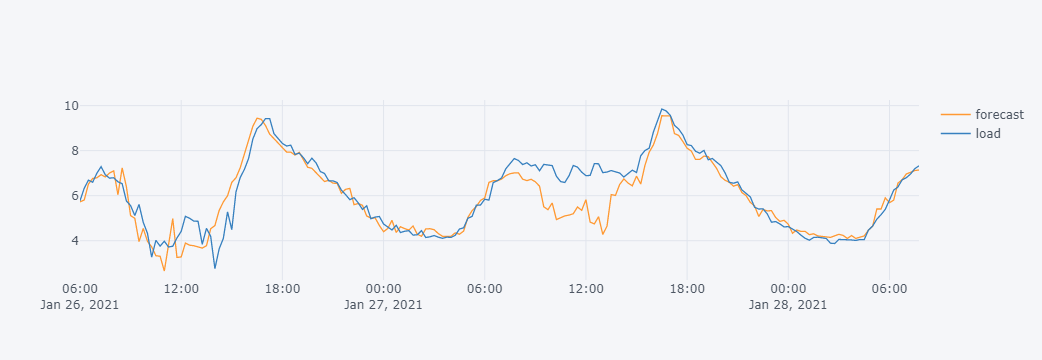

In [51]:
import cufflinks
cufflinks.go_offline()
forecast[['forecast','load']].iplot()

In [52]:
default_metrics ={
    "RMSE": metrics.rmse(forecast["load"], forecast["forecast"]),
    "bias": metrics.bias(forecast["load"], forecast["forecast"]),
    "NSME": metrics.nsme(forecast["load"], forecast["forecast"]),
    "MAE": metrics.mae(forecast["load"], forecast["forecast"]),
    "rMAE": metrics.r_mae(forecast["load"], forecast["forecast"]),
    "rMAE_highest": metrics.r_mae_highest(forecast["load"], forecast["forecast"]),
    "rMNE_highest": metrics.r_mne_highest(forecast["load"], forecast["forecast"]),
    "rMPE_highest": metrics.r_mpe_highest(forecast["load"], forecast["forecast"]),
    "rMAE_lowest": metrics.r_mae_lowest(forecast["load"], forecast["forecast"]),

    "load_range": forecast["load"].max() - forecast["load"].min(),
    "frac_in_1sdev": metrics.frac_in_stdev(forecast["load"], forecast["forecast"], forecast["stdev"]),
    "frac_in_2sdev": metrics.frac_in_stdev(
        forecast["load"], forecast["forecast"], 2 * forecast["stdev"]
    ),
}
pd.DataFrame.from_dict(default_metrics, "index")            

,0
RMSE,0.756802
bias,-0.223831
NSME,0.776115
MAE,0.494964
rMAE,0.069812
rMAE_highest,0.068826
rMNE_highest,-0.049685
rMPE_highest,0.049080
rMAE_lowest,0.112396
load_range,7.090000
